# Time series - multivariate prediction, feed-forward network

In this example we will load prepared data and try to predict it with the simple feed-forward network.

In [0]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = 30
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/ts_temp_dp_press.p'
training_df = pd.read_pickle(PATH)

Notice that we would randomly sample the training data from the whole weather history.

The `indices` array will contain starting date for each sample

In [0]:
import random

HISTORY_LEN = 14
PREDICTION_LEN = 7
NUM_SAMPLES = 2000
NUM_INPUTS = len(training_df.columns)

indices = random.sample(range(0,len(training_df) - HISTORY_LEN - PREDICTION_LEN), NUM_SAMPLES)

We need to reshape the data to a fixed-sized one-dimensional inputs and outputs

In [0]:
ts_data = training_df.values
ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices]).reshape((NUM_SAMPLES, HISTORY_LEN * NUM_INPUTS))
ts_outputs = np.array([ts_data[i + HISTORY_LEN: i + HISTORY_LEN + PREDICTION_LEN] for i in indices]).reshape((NUM_SAMPLES, PREDICTION_LEN * NUM_INPUTS))

Now, we build the feed-forward model.

Notice several details:
- dropout layers to mitigate possible overfitting.
- linear activation at the last layer (regression task)
- `mse` loss for regression instead of `crossentropy` for classification

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout

inputs = Input(shape=ts_inputs.shape[1:])
x = Dense(200, activation='tanh')(inputs)
x = Dropout(0.1)(x)
x = Dense(100, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(50, activation='tanh')(x)
x = Dropout(0.1)(x)
outputs = Dense(PREDICTION_LEN * NUM_INPUTS, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 56)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               11400     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0     

In [9]:
model.fit(ts_inputs, ts_outputs, validation_split=0.1, epochs=400)

Train on 1800 samples, validate on 200 samples
Epoch 1/400
1800/1800 [==============================] - 2s 1ms/sample - loss: 0.1629 - val_loss: 0.0729
Epoch 2/400
1800/1800 [==============================] - 0s 171us/sample - loss: 0.1012 - val_loss: 0.0687
Epoch 3/400
1800/1800 [==============================] - 0s 130us/sample - loss: 0.0887 - val_loss: 0.0686
Epoch 4/400
1800/1800 [==============================] - 0s 146us/sample - loss: 0.0833 - val_loss: 0.0653
Epoch 5/400
1800/1800 [==============================] - 0s 147us/sample - loss: 0.0800 - val_loss: 0.0655
Epoch 6/400
1800/1800 [==============================] - 0s 142us/sample - loss: 0.0789 - val_loss: 0.0651
Epoch 7/400
1800/1800 [==============================] - 0s 153us/sample - loss: 0.0754 - val_loss: 0.0644
Epoch 8/400
1800/1800 [==============================] - 0s 149us/sample - loss: 0.0737 - val_loss: 0.0646
Epoch 9/400
1800/1800 [==============================] - 0s 156us/sample - loss: 0.0729 - val_loss:

## Prediction phase

To test the prediction, we will take a particular date and feed the fixed-length history into the network

Notice the `DatetimeIndex` usage that allows us to easily align our prediction to the input time series.

In [0]:
import datetime
from datetime import timedelta

In [0]:
prediction_date = date(2013, 1, 7)

prediction_input = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]
prediction = model.predict(prediction_input.values.reshape(1, HISTORY_LEN * NUM_INPUTS))

history = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date + timedelta(days=PREDICTION_LEN)]
prediction_df = pd.DataFrame(prediction.reshape((PREDICTION_LEN, NUM_INPUTS)), index=pd.date_range(start=prediction_date + timedelta(days=1), freq='D', periods=PREDICTION_LEN))

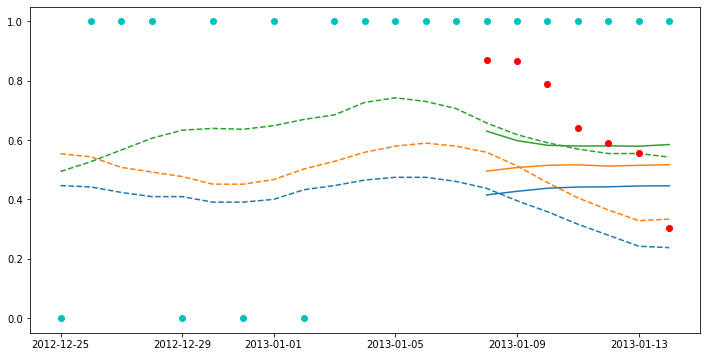

In [17]:
plt.figure(figsize = (12, 6))
history_plt = plt.plot(history.iloc[:,0:3], linestyle='--')
plt.plot(history.iloc[:,3], 'oc')
plt.plot(prediction_df.iloc[:,0], color=history_plt[0].get_color())
plt.plot(prediction_df.iloc[:,1], color=history_plt[1].get_color())
plt.plot(prediction_df.iloc[:,2], color=history_plt[2].get_color())
plt.plot(prediction_df.iloc[:,3], 'or')
plt.show()